<a href="https://colab.research.google.com/github/Lill98/classify_beed_dog/blob/master/breed_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp -r "/content/drive/My Drive/DL/Thuc_hanh/Breed_dog/dogImages.zip" ./data
!cp -r "/content/drive/My Drive/DL/Thuc_hanh/Breed_dog/DogVGG16Data.npz" ./bottleneck_features

In [ ]:
!unzip "/content/data/dogImages.zip" -d ./data

In [ ]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
  data=load_files(path)
  dog_files=np.array(data["filenames"])
  dog_targets=np_utils.to_categorical(np.array(data['target']),133)
  return dog_files,dog_targets
train_files,train_targets=load_dataset("/content/data/dogImages/train")
test_files,test_targets=load_dataset("/content/data/dogImages/test")
valid_files,valid_targets=load_dataset("/content/data/dogImages/valid")

Using TensorFlow backend.


In [ ]:
# load list of dog names
dog_names = [item[34:-1] for item in sorted(glob("/content/data/dogImages/train/*/"))]
print(dog_names)
print(len(dog_names))

In [ ]:
print(train_files[0],train_targets[0].shape)
# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

/content/data/dogImages/train/095.Kuvasz/Kuvasz_06442.jpg (133,)
There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [ ]:
from keras.applications.resnet50 import ResNet50
ResNet50_model=ResNet50(weights="imagenet")

In [ ]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
  img=image.load_img(img_path,target_size=(224,224))
  x=image.img_to_array(img)
  # print("image before process: ",x.shape)
  return np.expand_dims(x, axis=0)
def paths_to_tensor(img_paths):
  list_of_tensors=[path_to_tensor(img_path) for img_path in tqdm(img_paths)]
  # print(list_of_tensors)
  # print("np.vstack: ",np.vstack(list_of_tensors).shape)
  return np.vstack(list_of_tensors)

In [ ]:
from keras.applications.resnet50 import preprocess_input,decode_predictions

def RestNet50_predict_labels(img_path):
  print("4d",paths_to_tensor(img_path).shape)
  img=preprocess_input(paths_to_tensor(img_path))
  # print("image after preprocess: ",img[0])
  # print(ResNet50_model.predict(img))
  return np.argmax(ResNet50_model.predict(img))

In [ ]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = RestNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [ ]:
dog_detector(["/content/data/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg"])

100%|██████████| 1/1 [00:00<00:00, 321.99it/s]


4d (1, 224, 224, 3)


True

#CREATE A CNN TO CLASSIFY DOG BREED

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True

train_tensors=paths_to_tensor(train_files).astype("float32")/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

In [ ]:
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten,GlobalAveragePooling2D,MaxPooling2D
from keras.models import Sequential
import keras

In [ ]:
model=Sequential()
model.add(Conv2D(16,(5,5),padding="same",activation="relu",input_shape=(224,224,3)))
model.add(MaxPool2D(pool_size=(2,2),padding="valid"))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2,padding="same"))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(133,activation="softmax"))

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [ ]:
model.compile(optimizer="adam",loss=keras.losses.categorical_crossentropy,metrics=["accuracy"])

# TRAIN MODEL
C1: dont use augment


In [ ]:
epoch=500
checkpointer=keras.callbacks.ModelCheckpoint(filepath="/content/model/weights.{epoch:02d}-{val_loss:.2f}.hdf5",save_best_only=True)
model.fit(train_tensors,train_targets,validation_data=(valid_tensors,valid_targets),epochs=epoch,callbacks=[checkpointer],verbose=2)


In [ ]:
model.load_weights("/content/model/weights.05-9.65.hdf5")

In [ ]:
predict_label=np.argmax(model.predict(np.expand_dims(test_tensors[0],0)))
print(dog_names[predict_label])

Dalmatian


C2. AUGMENT

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
train_image_generator=ImageDataGenerator(rotation_range=40,width_shift_range=0.3,height_shift_range=0.3,horizontal_flip=True,zoom_range=0.2,shear_range=0.2,)
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
train_Data=train_image_generator.flow_from_directory(directory="/content/data/dogImages/train",target_size=(224,224),color_mode="rgb",class_mode="categorical")
valid_Data=validation_image_generator.flow_from_directory(directory="/content/data/dogImages/valid",target_size=(224,224),color_mode="rgb",class_mode="categorical")
test_Data=test_image_generator.flow_from_directory(directory="/content/data/dogImages/test",target_size=(224,224),color_mode="rgb",class_mode="categorical")

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Found 836 images belonging to 133 classes.


In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
train_tensor,train_label=next(train_Data)

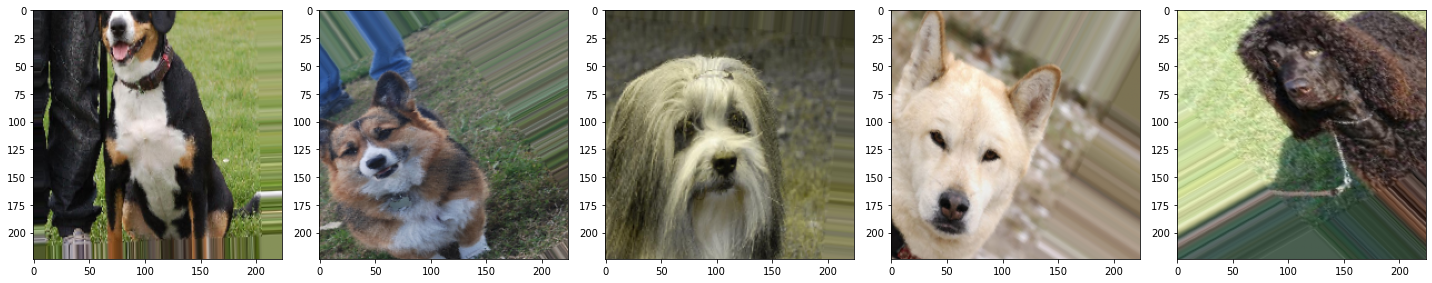

In [ ]:
plotImages(train_tensor[:5].astype("float")/255.0)

In [ ]:
epoch=400
batch_size=150
model.fit_generator(generator=train_Data,validation_data=valid_Data,epochs=epoch,verbose=2,steps_per_epoch=int(np.ceil(len(train_files)/batch_size)),use_multiprocessing=True)

Epoch 1/400
 - 40s - loss: 54.0718 - accuracy: 0.0111 - val_loss: 4.8839 - val_accuracy: 0.0072
Epoch 2/400
 - 36s - loss: 4.8916 - accuracy: 0.0111 - val_loss: 4.8829 - val_accuracy: 0.0096
Epoch 3/400
 - 34s - loss: 4.8893 - accuracy: 0.0077 - val_loss: 4.8986 - val_accuracy: 0.0096
Epoch 4/400
 - 34s - loss: 4.8905 - accuracy: 0.0069 - val_loss: 4.8799 - val_accuracy: 0.0108
Epoch 5/400
 - 34s - loss: 4.8880 - accuracy: 0.0111 - val_loss: 4.8832 - val_accuracy: 0.0108
Epoch 6/400
 - 33s - loss: 4.8845 - accuracy: 0.0105 - val_loss: 4.8657 - val_accuracy: 0.0108
Epoch 7/400
 - 33s - loss: 4.8871 - accuracy: 0.0097 - val_loss: 4.9239 - val_accuracy: 0.0108
Epoch 8/400
 - 34s - loss: 4.8844 - accuracy: 0.0083 - val_loss: 4.8937 - val_accuracy: 0.0108
Epoch 9/400
 - 34s - loss: 4.8852 - accuracy: 0.0104 - val_loss: 4.8518 - val_accuracy: 0.0108
Epoch 10/400
 - 35s - loss: 4.8821 - accuracy: 0.0097 - val_loss: 4.8785 - val_accuracy: 0.0108
Epoch 11/400
 - 34s - loss: 4.8800 - accuracy: 0

Process ForkPoolWorker-233:
Process ForkPoolWorker-232:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py", line 406, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)
  File "/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/iterator.py", line 230, in _get_batches_of_transformed_samples
    i

KeyboardInterrupt: ignored

In [ ]:
dog_breed_predictions=model.predict_generator(test_Data)


In [ ]:
predict_int=np.argmax(dog_breed_predictions,1)
print(predict_int)

[10 10 80 10 10  4 10  4 10 10 11  4  4 10  4 56  4 10  4  4 10 10 10 10
 10 10 10 10 11 10 10 10  4  4  4  4 10 10 10  4 10 33  4 10  4  4  4 11
 10 80 10 10 10 10  4  4 10 10  4 10  4 10  4  4 11  4  4 10  4  4  4 80
 10  4 11 10 56 10 10  4  4 56  4 10 10 10 10 10 10 10  4  4 10 10  4 10
  4  4  4 10 10  4 10  4 10 11  4 10 10  4 10  4  4 10 10  4 10 10 11 10
  4 10  4 10 10  4  4  4 10  4  4 10  4 10 10 11 10 10 10 10  4  4  4 10
 10 10 10 10 10  4  4  4 10  4 10 33 10 10 10  4 10 10 10 10 10 10 10  4
 10 10 10 10 10 10 10 10 10  4 10  4 10  4 10  4  4 10 10  4 10 10 10 10
 10 10 10 11 10 33 10 10 10 10 10 11  4  4 10 10 60 11  4  4 10 11 10 10
  4 10 10  4 10  4 10  4  4  4 11  4 10 10 10 10  4 10  4 10 10  4 10  4
  4 10  4 11  4  4  4 10  4  4  4 10 10  4  4 11 10 10 80 10  4 10  4 10
 56 10 10  4 10  4 10 33 10 10  4 10  4 11  4 10 10 10 11  4  4 10  4  4
 10  4  4 10 11 10 11 86 10  4  4  4  4  4  4 10 11 10 10  4  4  4 10 10
  4 10 10  4 10 10 10  4  4  4  4 10 10  4 10 10 10

#tranfer learning

In [ ]:
bottleneck_features = np.load('/content/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [ ]:
print(bottleneck_features.keys)

<bound method Mapping.keys of <numpy.lib.npyio.NpzFile object at 0x7f4fd65a0b00>>


In [ ]:
print(train_VGG16.shape)
print(valid_VGG16.shape)
print(test_VGG16.shape)

(6680, 7, 7, 512)
(835, 7, 7, 512)
(836, 7, 7, 512)


#  Ta sẽ tự tạo ra tập bottleneck_features bằng cách gọi model VGG16 bỏ đi lớp top rồi predict dữ liệu train, test,validation ta sẽ thu được dữ lieeujj như ở trên
chú ý: dùng predict thì mới trả về 1 tuple, nếu chỉ truyền tham số vào ta chỉ nhận được 1 tensor(base_model(test_tensor)- chỉ truyền mỗi ảnh chứ k truyền label vào)
ví dụ: [link](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [ ]:
base_model =keras.applications.VGG16(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
import tensorflow.keras.backend as K
data=K.constant(test_tensor)
print(data)

In [ ]:
feature_batch = base_model.predict_generator(test_Data,int(np.ceil(len(train_files)/15)))


lưu lại

In [ ]:
np.save(open('bottleneck_features_train.npy', 'w'), feature_batch)

Create model 

In [ ]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [ ]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='/content/model/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 3s 452us/step - loss: 7.8284 - accuracy: 0.2298 - val_loss: 3.5834 - val_accuracy: 0.4455

Epoch 00001: val_loss improved from inf to 3.58342, saving model to /content/model/weights.best.VGG16.hdf5
Epoch 2/20
6680/6680 [==============================] - 1s 216us/step - loss: 2.1868 - accuracy: 0.5940 - val_loss: 2.5462 - val_accuracy: 0.5844

Epoch 00002: val_loss improved from 3.58342 to 2.54623, saving model to /content/model/weights.best.VGG16.hdf5
Epoch 3/20
6680/6680 [==============================] - 1s 213us/step - loss: 1.2365 - accuracy: 0.7413 - val_loss: 2.1139 - val_accuracy: 0.6551

Epoch 00003: val_loss improved from 2.54623 to 2.11390, saving model to /content/model/weights.best.VGG16.hdf5
Epoch 4/20
6680/6680 [==============================] - 1s 214us/step - loss: 0.8022 - accuracy: 0.8142 - val_loss: 1.9418 - val_accuracy: 0.6695

Epoch 00004: val_loss improved from 

In [ ]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 74.0431%


In [ ]:
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in K.eval(feature_batch)]

In [ ]:
predict_int=np.argmax(dog_breed_predictions,1)
print(predict_int)